# Natural Language Processing: Feature and Model Selection 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Generating text corpus

We will generate three types of words: noise, classA and classB. Each type will have a probability distribution. Each word in each type will also have a probability distribution. We will start with 50 words of each type. 

Let's start out trying a few ideas. To begin with, this function creates "random words" with a (slightly modified) normal distribution.

In [3]:
# random word generator
def random_normal_word(mean,std,name):
    number = np.random.normal(mean,std)
    number = np.abs(number).astype('int64')
    word = name + str(number)
    return word

In [4]:
# example
random_normal_word(4000,1000,'noise')

'noise1267'

In [5]:
# function to return index of random variable
# based on probability
def proba_to_index(proba,proba_list):
    index = 0
    cum_proba = np.cumsum(proba_list)
    for i in range(len(cum_proba)):
        if proba < cum_proba[i]:
            index = i
            break
    return index

In [6]:
def generate_text(percents,min_len,max_len):
    '''
    percents is a list with the percentage of each type in the text.
    percents[0] => 'classA'
    percents[1] => 'classB'
    percents[2] => 'noise'
    '''
    classes = ['classA','classB','noise']
    length = np.random.randint(min_len,max_len)
    text = ''
    for i in range(length):
        class_proba = np.random.random()
        index = proba_to_index(class_proba,percents)
        name = classes[index]
        word = random_normal_word(4000,1000,name)
        text += word + ' '
    return text

In [7]:
example = generate_text([0.3,0.1,0.6],500,1000)
example[0:500]

'classB5308 noise2820 noise4783 noise4633 noise3652 classA4478 noise3905 noise2907 classA2372 classA4094 noise5944 classB3612 classA3931 noise3884 classA4416 noise2920 noise4355 classA5447 noise6151 classB2683 noise3601 noise3194 classA3891 noise4625 classA3789 noise5064 noise4585 noise3093 noise5084 noise4866 noise4630 noise4816 noise3725 classA5770 noise3275 noise2702 noise4453 noise2882 noise5373 classA2873 noise5402 classA4940 noise2311 classB4052 noise3201 classB1919 classA5678 noise6021 noi'

In [8]:
# sanity check
count_noise,count_A, count_B = 0,0,0
for word in example.split():
    if word.startswith('noise'):
        count_noise += 1
    elif word.startswith('classA'):
        count_A += 1
    else:
        count_B += 1
print(f'Total words\nNoise: {count_noise}\nClass A: {count_A}\nClass B: {count_B}')

Total words
Noise: 499
Class A: 235
Class B: 80


We are ready to generate our corpus. We will construct 1000 samples of between 500 and 1000 words each.

In [9]:
# Let's say classes are split 60/40
random_list = np.random.random(2000)
target_list = []
for r in random_list:
    if r < 0.6:
        target_list.append(1)
    else:
        target_list.append(0)

len(target_list)

2000

In [10]:
df = pd.DataFrame()
df['target'] = target_list
df.head()

,target
0,1
1,0
2,1
3,1
4,1


In [11]:
# create text for each instance
# class A = 0, class B = 1
df['text'] = ''
df['text'].astype('object')
for i in df.index:
    if df.at[i,'target'] == 1:
        text = generate_text([0.1,0.3,0.6],500,1000)
        df.at[i,'text'] = text
    else:
        text = generate_text([0.3,0.1,0.6],500,1000)
        df.at[i,'text'] = text

In [12]:
df.head()

,target,text
0,1,noise5713 classB3142 classB3654 noise4342 nois...
1,0,noise4931 classB2877 noise4053 noise3522 noise...
2,1,noise4347 noise3081 classB4933 noise3397 noise...
3,1,classA4770 classB6374 noise3429 noise4675 nois...
4,1,classB3454 noise6398 noise5217 noise2025 noise...


In [13]:
# class A instances
dfA = df[df.target == 0]
# proportion
dfA.shape[0] / df.shape[0]

0.392

In [15]:
# sanity check: class A percentage of words
# in class A instances
count_total = 0
count_A = 0
for i in dfA.index:
    text = dfA.at[i,'text']
    count_total += len(text.split())
    for w in text.split():
        if w.startswith('classA'):
            count_A += 1
print(f'Proporcion: {count_A / count_total}')

Proporcion: 0.30095817126362945


## Tf-idf demonstration

In [16]:
# df creation
df_trial = pd.DataFrame()
df_trial['target'] = [0,0,0,1,1,0]
df_trial

,target
0,0
1,0
2,0
3,1
4,1
5,0


In [17]:
# adding text column with made up words
df_trial.at[0,'text'] = 'a1 a1 b1 a1 c1 z1'
df_trial.at[1,'text'] = 'b1 a1 b1 b1 c1 c1'
df_trial.at[2,'text'] = 'b1 a1 b1 a1 c1 c1'
df_trial.at[3,'text'] = 'b1 a1 x1 z1'
df_trial.at[4,'text'] = 'a1'
df_trial.at[5,'text'] = 'a1 z1'
df_trial

,target,text
0,0,a1 a1 b1 a1 c1 z1
1,0,b1 a1 b1 b1 c1 c1
2,0,b1 a1 b1 a1 c1 c1
3,1,b1 a1 x1 z1
4,1,a1
5,0,a1 z1


### Sci-kit learn

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(lowercase=True)
fit_vectorizer = vectorizer.fit(df_trial.text)
tfidf_trial = fit_vectorizer.transform(df_trial.text)

In [19]:
tfidf_trial.shape

(6, 5)

In [ ]:
# list of words in corpus
fit_vectorizer.get_feature_names()

In [20]:
# dictionary matching word to matrix column
fit_vectorizer.vocabulary_

{'a1': 0, 'b1': 1, 'c1': 2, 'z1': 4, 'x1': 3}

In [21]:
# dense matrix representation
tfidf_trial.todense()

matrix([[0.75831693, 0.33782317, 0.39422769, 0.        , 0.39422769],
        [0.19314873, 0.77441376, 0.60247563, 0.        , 0.        ],
        [0.43774852, 0.58503874, 0.6827195 , 0.        , 0.        ],
        [0.31168683, 0.4165608 , 0.        , 0.70215656, 0.48611171],
        [1.        , 0.        , 0.        , 0.        , 0.        ],
        [0.53976033, 0.        , 0.        , 0.        , 0.84181874]])

In [22]:
# array representation
trial_arr = tfidf_trial.toarray()
trial_arr

array([[0.75831693, 0.33782317, 0.39422769, 0.        , 0.39422769],
       [0.19314873, 0.77441376, 0.60247563, 0.        , 0.        ],
       [0.43774852, 0.58503874, 0.6827195 , 0.        , 0.        ],
       [0.31168683, 0.4165608 , 0.        , 0.70215656, 0.48611171],
       [1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.53976033, 0.        , 0.        , 0.        , 0.84181874]])

In [23]:
# apply function to each column
np.apply_along_axis(np.sum,0,trial_arr)

array([3.24066135, 2.11383648, 1.67942281, 0.70215656, 1.72215813])

The above function gives us the sum of tf-idf values for each column. We will use it later for mean tf-idf.

In [24]:
# sparse representation
print(tfidf_trial)

  (0, 4)	0.39422768553293636
  (0, 2)	0.39422768553293636
  (0, 1)	0.3378231745907559
  (0, 0)	0.7583169302001058
  (1, 2)	0.6024756322681024
  (1, 1)	0.7744137645910423
  (1, 0)	0.19314873474884586
  (2, 2)	0.6827194968035845
  (2, 1)	0.5850387383458417
  (2, 0)	0.4377485160671207
  (3, 4)	0.4861117058129096
  (3, 3)	0.70215655540208
  (3, 1)	0.4165607989744412
  (3, 0)	0.3116868331118981
  (4, 0)	1.0
  (5, 4)	0.8418187357325301
  (5, 0)	0.5397603321564903


In [30]:
# choose specific word columns
# say I want to choose columns for 'b1' and 'z1'
words = ['b1','z1']
columns = []
for w in words:
    column = fit_vectorizer.vocabulary_[w]
    columns.append(column)
columns

[1, 4]

In [34]:
filt_arr = trial_arr[:,columns]
filt_arr

array([[0.33782317, 0.39422769],
       [0.77441376, 0.        ],
       [0.58503874, 0.        ],
       [0.4165608 , 0.48611171],
       [0.        , 0.        ],
       [0.        , 0.84181874]])

Notice that there are methods that belong to <b>the vectorizer</b> (vocabulary,get_feature_names()) and there are methods that belong to <b>the matrix</b> (todense(),toarray()). 

## Word Frequency in our corpus

In [35]:
bag = []
bag_neg = []
bag_pos = []
for i in df.index:
    word_list = df.text[i].split()
    bag.extend(word_list)
    if df.target[i] == 1:
        bag_pos.extend(word_list)
    else:
        bag_neg.extend(word_list)
print(f'Total words: {len(bag)}')
if len(bag) - len(bag_pos) - len(bag_neg) == 0:
    print('Sum of words OK')
else:
    print('Please check')

Total words: 1512554
Sum of words OK


In [50]:
import nltk
freq_bag = nltk.FreqDist(bag)
freq_df = pd.DataFrame(list(freq_bag.items()), columns = ["Word","TotFreq"])
freq_df.head()

,Word,TotFreq
0,noise5713,82
1,classB3142,104
2,classB3654,122
3,noise4342,372
4,noise4411,331


In [51]:
print(f'Total words: {freq_df.shape[0]}')

Total words: 20183


## Tf-idf vectorization in our corpus

In [106]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(lowercase=False)
fit_df_vectorizer = vectorizer.fit(df.text)
tfidf_df = fit_df_vectorizer.transform(df.text)

In [87]:
# vectorizer for each class
A_vectorizer = TfidfVectorizer(lowercase=False)
fit_A_vectorizer = A_vectorizer.fit(df.text)
df_A = df[df.target == 0]
tfidf_A = fit_A_vectorizer.transform(df_A.text)

B_vectorizer = TfidfVectorizer(lowercase=False)
fit_B_vectorizer = B_vectorizer.fit(df.text)
df_B = df[df.target == 1]
tfidf_B = fit_B_vectorizer.transform(df_B.text)

In [107]:
# create array of tf-idf mean value 
# for each df and for each word
total_means = np.apply_along_axis(np.mean,0,
                                  tfidf_df.toarray())
A_means = np.apply_along_axis(np.mean,0,
                                  tfidf_A.toarray())
B_means = np.apply_along_axis(np.mean,0,
                                  tfidf_B.toarray())

In [99]:
A_means[0:10]

array([1.02969725e-04, 2.11153938e-04, 1.84836182e-04, 0.00000000e+00,
       1.64231499e-04, 9.02864600e-05, 7.91836269e-05, 7.82658757e-05,
       8.32033902e-05, 1.91154825e-04])

In [90]:
B_means[0:10]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.56994517e-05,
       5.11608022e-05, 0.00000000e+00, 6.72281372e-05, 5.79088200e-05,
       0.00000000e+00, 5.52993287e-05])

In [109]:
# list of words and indices
df_words = fit_df_vectorizer.get_feature_names()
df_indices = fit_df_vectorizer.vocabulary_
A_words = fit_A_vectorizer.get_feature_names()
A_indices = fit_A_vectorizer.vocabulary_
B_words = fit_B_vectorizer.get_feature_names()
B_indices = fit_B_vectorizer.vocabulary_

In [111]:
# add tf-idf values for each word to word df
for i in freq_df.index:
    word = freq_df.at[i,'Word']
    col_index = df_indices[word]
    freq_df.at[i,'tf-idf'] = total_means[col_index]
    if word in A_words:
        col_A_index = A_indices[word]
        freq_df.at[i,'tf-idf_A'] = A_means[col_A_index]
    if word in B_words:
        col_B_index = B_indices[word]
        freq_df.at[i,'tf-idf_B'] = B_means[col_B_index]

freq_df.head()

,Word,TotFreq,tf-idf,tf-idf_A,tf-idf_B
0,noise5713,82,0.001598,0.001364,0.001748
1,classB3142,104,0.001888,0.000564,0.002742
2,classB3654,122,0.002177,0.001278,0.002756
3,noise4342,372,0.004766,0.004636,0.004850
4,noise4411,331,0.004454,0.004228,0.004600


In [112]:
# normalized difference for ease of display
freq_df['diff'] = (freq_df['tf-idf_A'] - freq_df['tf-idf_B'])*10000
freq_df['abs_diff'] = abs(freq_df['diff'])
freq_df = freq_df.sort_values(by='abs_diff',ascending=False)
freq_df.head(7)

,Word,TotFreq,tf-idf,tf-idf_A,tf-idf_B,diff,abs_diff
7205,classA3897,130,0.002282,0.004322,0.000966,33.552447,33.552447
3351,classA3634,122,0.002147,0.004186,0.000832,33.545183,33.545183
2469,classA3990,112,0.002052,0.004090,0.000738,33.519792,33.519792
9522,classA4049,117,0.002082,0.004074,0.000798,32.760406,32.760406
9944,classA4041,119,0.002131,0.004108,0.000857,32.507099,32.507099
957,classA3989,139,0.002369,0.004340,0.001098,32.420633,32.420633
3568,classA3684,111,0.002021,0.003964,0.000769,31.950291,31.950291


In [113]:
freq_df.tail(7)

,Word,TotFreq,tf-idf,tf-idf_A,tf-idf_B,diff,abs_diff
13580,classA1533,5,0.000144,0.000144,0.000144,0.004924,0.004924
5999,noise3192,275,0.003841,0.003840,0.003841,-0.004658,0.004658
15200,noise1465,21,0.000543,0.000543,0.000543,-0.004637,0.004637
13370,classB6998,3,0.000101,0.000102,0.000101,0.003846,0.003846
6651,noise1111,5,0.000158,0.000157,0.000158,-0.001541,0.001541
17158,noise1142,5,0.000157,0.000157,0.000157,-0.000904,0.000904
9716,noise6439,19,0.000494,0.000494,0.000494,0.000180,0.000180


We can see the pattern here: the words with more (absolute) tf-idf difference for the two classes are the most frequent words of the most frequent class. That is, the word number is near the mean of the underlying normal distribution (which was if 4000 you recall) and the class is the most prevalent one (A). On the other hand, the least difference belongs to words that are noise or unfrequent words. 

(In the following section we study a slightly different strategy, that will give A and B words a similar importance, and leave noise words further behind). 

Let's plot it.

In [114]:
# word class to compare
for i in freq_df.index:
    word = freq_df.at[i,'Word']
    if word.startswith('noise'):
        freq_df.at[i,'class'] = 'noise'
    elif word.startswith('classA'):
        freq_df.at[i,'class'] = 'A'
    else:
        freq_df.at[i,'class'] = 'B'

In [115]:
freq_df.head()

,Word,TotFreq,tf-idf,tf-idf_A,tf-idf_B,diff,abs_diff,class
7205,classA3897,130,0.002282,0.004322,0.000966,33.552447,33.552447,A
3351,classA3634,122,0.002147,0.004186,0.000832,33.545183,33.545183,A
2469,classA3990,112,0.002052,0.004090,0.000738,33.519792,33.519792,A
9522,classA4049,117,0.002082,0.004074,0.000798,32.760406,32.760406,A
9944,classA4041,119,0.002131,0.004108,0.000857,32.507099,32.507099,A


In [116]:
freq_A = freq_df[freq_df['class'] == 'A']
freq_A = freq_A.sort_values(by='abs_diff',ascending=False).head(7)
freq_noise = freq_df[freq_df['class'] == 'noise']
freq_noise = freq_noise.sort_values(by='abs_diff',ascending=False).head(7)
freq_B = freq_df[freq_df['class'] == 'B']
freq_B = freq_B.sort_values(by='abs_diff',ascending=False).head(7)

In [117]:
freq_A

,Word,TotFreq,tf-idf,tf-idf_A,tf-idf_B,diff,abs_diff,class
7205,classA3897,130,0.002282,0.004322,0.000966,33.552447,33.552447,A
3351,classA3634,122,0.002147,0.004186,0.000832,33.545183,33.545183,A
2469,classA3990,112,0.002052,0.004090,0.000738,33.519792,33.519792,A
9522,classA4049,117,0.002082,0.004074,0.000798,32.760406,32.760406,A
9944,classA4041,119,0.002131,0.004108,0.000857,32.507099,32.507099,A
957,classA3989,139,0.002369,0.004340,0.001098,32.420633,32.420633,A
3568,classA3684,111,0.002021,0.003964,0.000769,31.950291,31.950291,A


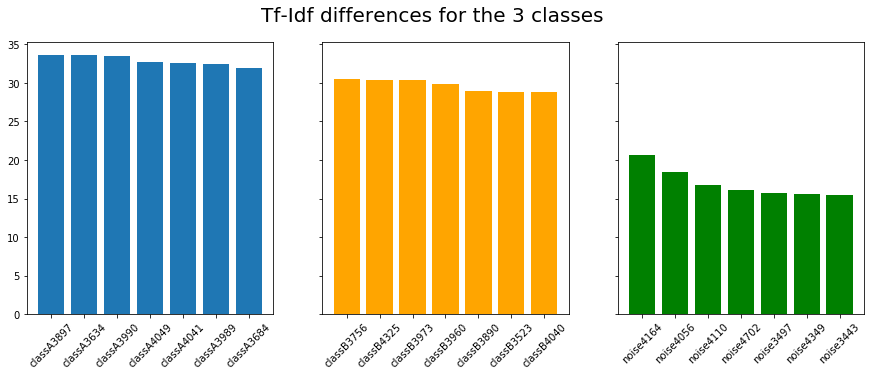

In [118]:
fig,ax = plt.subplots(1,3,figsize=(15,5),sharey=True)
ax[0].bar(freq_A.Word,freq_A.abs_diff)
ax[0].set_xticklabels(freq_A.Word, rotation=45)
ax[1].bar(freq_B.Word,freq_B.abs_diff,color='orange')
ax[1].set_xticklabels(freq_B.Word, rotation=45)
ax[2].bar(freq_noise.Word,freq_noise.abs_diff,color='green')
ax[2].set_xticklabels(freq_noise.Word, rotation=45)
plt.suptitle('Tf-Idf differences for the 3 classes',size=20)
plt.show()

## Functions for generalizing this tasks

In [154]:
def df_to_bag(df_X):
    '''
    Takes df_X (string), return bag of words
    (in df format)
    Requires NLTK
    '''
    bag = []
    for i in df_X.index:
        word_list = df_X[i].split()
        bag.extend(word_list)
    freq_bag = nltk.FreqDist(bag)
    bag_df = pd.DataFrame(list(freq_bag.items()), columns = ["Word","TotFreq"])
    return bag_df

In [122]:
func_bag = df_to_bag(df.text)
func_bag.head()

,Word,TotFreq
0,noise5713,164
1,classB3142,208
2,classB3654,244
3,noise4342,744
4,noise4411,662


In [215]:
def df_to_tfidf(df,text_col,target,fit='cat'):
    '''
    Takes as input a df and the name of the target column.
    Returns a list with information about each category:
    category name, tf-idf matrix, tf-idf mean for each word
    Requires pandas,sklearn TdidfVectorizer
    fit parameter: if 'df', tf-idf Vectorizer fit on whole df.
    if 'cat', fit in each category
    '''
    tfidf_list = []
    X = df[text_col]
    y = df[target]
    vectorizer = TfidfVectorizer(lowercase=False)
    df_vecto = vectorizer.fit(X)
    fit_vecto = df_vecto.transform(X)
    means_arr = np.apply_along_axis(np.mean,0,
                                  fit_vecto.toarray())
    tfidf_list.append(['df',df_vecto,fit_vecto,means_arr])
    for i in y.unique():
        vect_aux = TfidfVectorizer(lowercase=False)
        if fit == 'cat':
            df_aux = df[df[target] == i]
            X_aux = df_aux[text_col]
            vect_aux_transf = vect_aux.fit_transform(X_aux)
        elif fit == 'df':
            vect_aux_fit = vect_aux.fit(X)
            df_aux = df[df[target] == i]
            X_aux = df_aux[text_col]
            vect_aux_transf = vect_aux.transform(X_aux)
        means_arr = np.apply_along_axis(np.mean,0,
                                  vect_aux_transf.toarray())
        tfidf_list.append([i,vect_aux,
                           vect_aux_transf,means_arr])
    return tfidf_list

In [124]:
func_tfidf = df_to_tfidf(df,'text','target')
func_tfidf[0]

['df', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.float64'>, encoding='utf-8',
                 input='content', lowercase=False, max_df=1.0, max_features=None,
                 min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                 smooth_idf=True, stop_words=None, strip_accents=None,
                 sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, use_idf=True, vocabulary=None), <2000x20183 sparse matrix of type '<class 'numpy.float64'>'
 	with 1439577 stored elements in Compressed Sparse Row format>, array([4.03641320e-05, 8.27723435e-05, 7.24557832e-05, ...,
        3.78045481e-05, 9.86634495e-05, 6.10642486e-05])]

In [197]:
def tfidf_cat(bag_df,tfidf_list):
    '''
    Takes a bag of words df extracted from a
    dataset, its corresponding tf-idf list 
    (containing category names, tf-idf object, 
    tf-idf mean values for each category and word)
    Returns a df with tf-idf values and differences
    for each word.
    bag_df must have a 'Word' column
    '''
    df_words = tfidf_list[0][1].get_feature_names()
    df_indices = tfidf_list[0][1].vocabulary_
    for i in bag_df.index:
        # assign tf-idf values to each word (total)
        word = bag_df.at[i,'Word']
        col_index = df_indices[word]
        df_means = tfidf_list[0][3]
        bag_df.at[i,'tf-idf'] = df_means[col_index]
        # assign tf-idf values to each word (each category)
        for j in range(1,len(tfidf_list)):
            cat_words = tfidf_list[j][1].get_feature_names()
            cat_name = tfidf_list[j][0]
            if word not in cat_words:
                bag_df.at[i,'tf-idf_'+str(cat_name)] = 0
            else:
                cat_indices = tfidf_list[j][1].vocabulary_
                col_index = cat_indices[word]
                cat_means = tfidf_list[j][3]
                bag_df.at[i,'tf-idf_'+str(cat_name)] = cat_means[col_index]
    return bag_df

In [183]:
func_df = tfidf_cat(func_bag,func_tfidf)
func_df.head()

,Word,TotFreq,tf-idf,tf-idf_1,tf-idf_0
0,noise5713,164,0.001598,0.001733,0.001445
1,classB3142,208,0.001888,0.002521,0.000735
2,classB3654,244,0.002177,0.002630,0.001466
3,noise4342,744,0.004766,0.004863,0.004833
4,noise4411,662,0.004454,0.004624,0.004386


In [159]:
def col_diff(df,col0,col1):
    df['diff'] = (df[col0] - df[col1])*10000
    df['abs_diff'] = np.abs(df['diff'])
    df = df.sort_values(by='abs_diff',ascending=False)
    return df

In [202]:
func_df = col_diff(func_df,'tf-idf_1','tf-idf_0')
func_df.head()

,Word,TotFreq,tf-idf,tf-idf_1,tf-idf_0,diff,abs_diff
2469,classA3990,224,0.002052,0.000923,0.003492,-25.694313,25.694313
3351,classA3634,244,0.002147,0.001032,0.003576,-25.439023,25.439023
7205,classA3897,260,0.002282,0.001186,0.003710,-25.238741,25.238741
9522,classA4049,234,0.002082,0.000994,0.003480,-24.859073,24.859073
9327,classB3973,270,0.002349,0.003196,0.000715,24.812624,24.812624


In [470]:
# values to plot
func_freq_A = func_df[func_df['Word'].apply(lambda x: x.startswith('classA'))]
func_freq_A = func_freq_A.sort_values(by='abs_diff',ascending=False).head(7)
func_freq_noise = func_df[func_df['Word'].apply(lambda x: x.startswith('noise'))]
func_freq_noise = func_freq_noise.sort_values(by='abs_diff',ascending=False).head(7)
func_freq_B = func_df[func_df['Word'].apply(lambda x: x.startswith('classB'))]
func_freq_B = func_freq_B.sort_values(by='abs_diff',ascending=False).head(7)

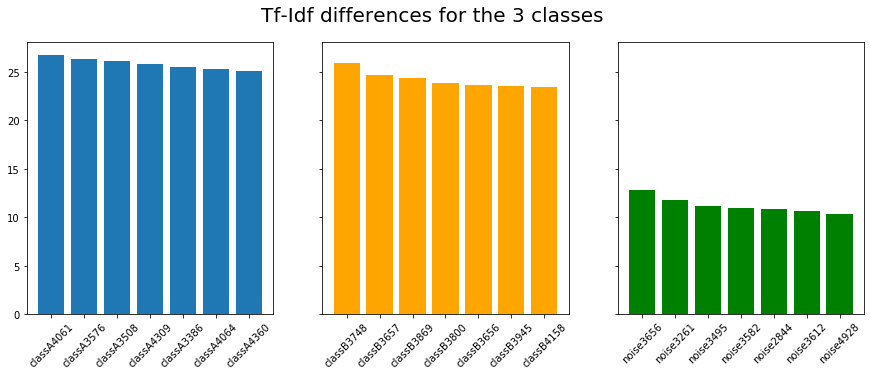

In [472]:
# plots
fig,ax = plt.subplots(1,3,figsize=(15,5),sharey=True)
ax[0].bar(func_freq_A.Word,func_freq_A.abs_diff)
ax[0].set_xticklabels(func_freq_A.Word, rotation=45)
ax[1].bar(func_freq_B.Word,func_freq_B.abs_diff,color='orange')
ax[1].set_xticklabels(freq_B.Word, rotation=45)
ax[2].bar(func_freq_noise.Word,func_freq_noise.abs_diff,color='green')
ax[2].set_xticklabels(func_freq_noise.Word, rotation=45)
plt.suptitle('Tf-Idf differences for the 3 classes',size=20)
plt.show()

Notice the difference between this plot and the previous one. The difference is in the way the tf-idf matrix is fit and transformed. In the previous section version, we fit the vectorizer to the whole dataframe (tf-idf values are calculated from the full bag of words); in this one, we fit it to a dataframe filtered by each category. We will study the performance of each in the next section.

In [225]:
# wrapping function
def df_to_freq_df(df,target='target',text_col='text',
                 fit='cat'):
    bag_df = df_to_bag(df[text_col])
    tfidf_list = df_to_tfidf(df,text_col=text_col,
                            target=target,fit=fit)
    bag_df = tfidf_cat(bag_df,tfidf_list)
    target0 = str(df[target].unique()[0])
    target1 = str(df[target].unique()[1])
    col0 = 'tf-idf_'+target0
    col1 = 'tf-idf_'+target1
    freq_df = col_diff(bag_df,col0,
                       col1)
    return (freq_df,tfidf_list)

In [217]:
wrap_df = df_to_freq_df(df)
wrap_df[0].head(10)

,Word,TotFreq,tf-idf,tf-idf_1,tf-idf_0,diff,abs_diff
2469,classA3990,112,0.002052,0.000923,0.003492,-25.694313,25.694313
3351,classA3634,122,0.002147,0.001032,0.003576,-25.439023,25.439023
7205,classA3897,130,0.002282,0.001186,0.003710,-25.238741,25.238741
9522,classA4049,117,0.002082,0.000994,0.003480,-24.859073,24.859073
9327,classB3973,135,0.002349,0.003196,0.000715,24.812624,24.812624
3568,classA3684,111,0.002021,0.000947,0.003411,-24.639735,24.639735
9944,classA4041,119,0.002131,0.001060,0.003517,-24.574077,24.574077
8446,classB3756,147,0.002509,0.003354,0.000906,24.484569,24.484569
2227,classB4325,146,0.002529,0.003377,0.000931,24.468244,24.468244
7974,classB3960,146,0.002495,0.003341,0.000911,24.292312,24.292312


In [218]:
wrap2_df = df_to_freq_df(df,fit='df')
wrap2_df[0].head(10)

,Word,TotFreq,tf-idf,tf-idf_1,tf-idf_0,diff,abs_diff
7205,classA3897,130,0.002282,0.000966,0.004322,-33.552447,33.552447
3351,classA3634,122,0.002147,0.000832,0.004186,-33.545183,33.545183
2469,classA3990,112,0.002052,0.000738,0.004090,-33.519792,33.519792
9522,classA4049,117,0.002082,0.000798,0.004074,-32.760406,32.760406
9944,classA4041,119,0.002131,0.000857,0.004108,-32.507099,32.507099
957,classA3989,139,0.002369,0.001098,0.004340,-32.420633,32.420633
3568,classA3684,111,0.002021,0.000769,0.003964,-31.950291,31.950291
7030,classA4260,98,0.001815,0.000590,0.003715,-31.246026,31.246026
8752,classA3738,117,0.002088,0.000864,0.003986,-31.224022,31.224022
1889,classA3695,106,0.001926,0.000704,0.003821,-31.169268,31.169268


## Other Univariate Feature Selection Strategies

### Comparison Metric

To compare between the different strategies, we will use the following metric: the mean of the (ordered) indices corresponding to noise variables in the ranking. The higher this metric, the more the strategy separates noise from structure. We will start by calculating this metric for our tf-idf dataframes.

In [432]:
wrap_df_ord = wrap_df.reset_index(drop=True)
tfidf_cat_ranks = []
for i in wrap_df_ord.index:
    word = wrap_df_ord.at[i,'Word']
    if word.startswith('noise'):
        tfidf_cat_ranks.append(i)

print(f'First indices: {tfidf_cat_ranks[0:10]}')
print(f'Mean: {np.mean(tfidf_cat_ranks)}')
print(f'Median: {np.median(tfidf_cat_ranks)}')

First indices: [2731, 3507, 3570, 4228, 4292, 4312, 4348, 4419, 4455, 4509]
Mean: 13632.84420289855
Median: 13743.0


In [342]:
wrap2_df_ord = wrap2_df.reset_index(drop=True)
tfidf_df_ranks = []
for i in wrap2_df_ord.index:
    word = wrap2_df_ord.at[i,'Word']
    if word.startswith('noise'):
        tfidf_df_ranks.append(i)

print(f'First indices: {tfidf_df_ranks[0:10]}')
print(f'Mean: {np.mean(tfidf_df_ranks)}')
print(f'Median: {np.median(tfidf_df_ranks)}')

First indices: [1379, 2221, 2958, 3230, 3390, 3449, 3511, 3539, 3652, 3842]
Mean: 13405.361482720178
Median: 13457.0


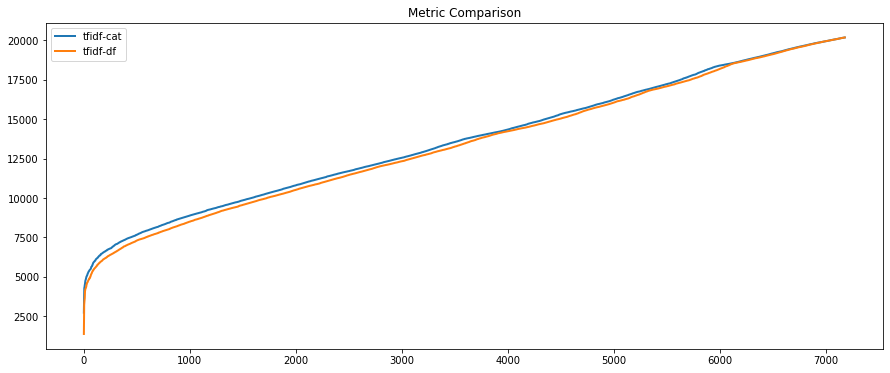

In [337]:
plt.figure(figsize=(15,6))
y = tfidf_cat_ranks
x = range(len(y))
plt.plot(x,y,linewidth=2,label='tfidf-cat')
y = tfidf_df_ranks
x = range(len(y))
plt.plot(x,y,linewidth=2,label='tfidf-df')
plt.legend()
plt.title('Metric Comparison')
plt.show()

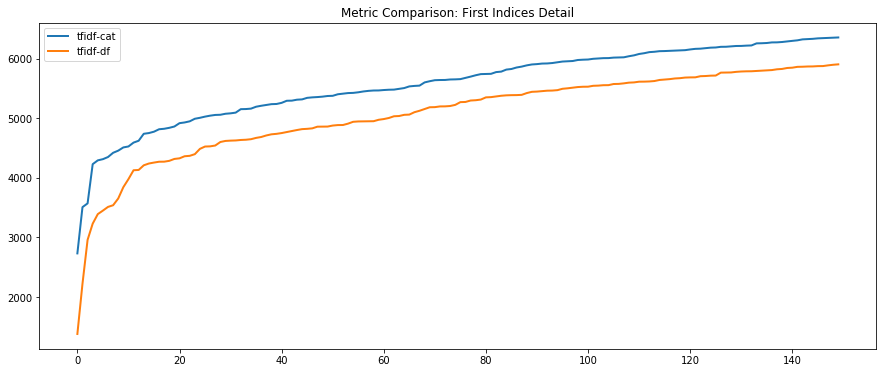

In [340]:
plt.figure(figsize=(15,6))
y = tfidf_cat_ranks[0:150]
x = range(len(y))
plt.plot(x,y,linewidth=2,label='tfidf-cat')
y = tfidf_df_ranks[0:150]
x = range(len(y))
plt.plot(x,y,linewidth=2,label='tfidf-df')
plt.legend()
plt.title('Metric Comparison: First Indices Detail')
plt.show()

We can see that the first strategy (fit='cat') selects relevant features better. 

### Mutual Information with Count Vectorizer

In [346]:
from sklearn.feature_selection import mutual_info_classif,chi2
from sklearn.feature_extraction.text import CountVectorizer

In [461]:
df_reset = df.reset_index(drop=True)
df_reset.head()

,target,text
0,0,noise4570 noise3387 classB2461 noise3036 class...
1,1,classB5653 noise4405 noise2891 classB5318 nois...
2,1,noise1618 noise2452 classB4410 classB5246 nois...
3,1,classB3709 noise5230 noise4334 noise1937 noise...
4,1,noise3651 noise2258 noise3635 classB4354 noise...


In [423]:
cv = CountVectorizer(lowercase=False)
count_mat = cv.fit_transform(df_reset.text)

In [427]:
count_mat.shape

(2000, 20183)

In [424]:
df_reset.at[0,'text'][0:500]

'noise4570 noise3387 classB2461 noise3036 classB4340 noise4417 noise5334 classA3834 noise5717 noise3928 noise4617 classA3201 noise3035 noise6585 noise3345 classA5329 noise2696 noise2107 noise3445 classB3062 classA4552 noise4483 classA5439 noise4546 noise3727 classA3919 noise4277 noise5193 noise3346 noise7160 noise3568 noise3599 noise4738 classB3150 noise4742 classA3326 classA4720 classA3072 classB2536 noise3381 classB3476 classA4082 classA1330 noise4586 classB4600 classB3969 noise4665 classB3554 '

In [425]:
# let's check the result
# create a dictionary with word count for first instance
string = df_mi.at[0,'text']
word_count = {}
for w in string.split():
    if w in word_count.keys():
        word_count[w] += 1
    else:
        word_count[w] = 1

In [430]:
# check the results with my fit_transform matrix
for w in word_count.keys():
    col = cv.vocabulary_[w]
    cv_value = count_mat.toarray()[0,col]
    my_value = word_count[w]
    if cv_value != my_value:
        print(f'Error in word {w}')
else:
    print('Check OK!')

Check OK!


In [431]:
mi_count = mutual_info_classif(count_mat,y)
mi_count

array([4.68440712e-04, 4.97903050e-04, 9.37269869e-04, ...,
       2.48870826e-04, 7.47096885e-04, 2.39142325e-05])

In [433]:
mi_count.shape

(20183,)

In [456]:
# create df for this classifier
mi_count_df = pd.DataFrame()
word_list = cv.get_feature_names()
for i,w in enumerate(word_list):
    mi_count_df.at[i,'Word'] = w
    index = cv.vocabulary_[w]
    mi_count_df.at[i,'mi'] = mi_count[index]

In [457]:
mi_count_df.head()

,Word,mi
0,classA1000,0.000468
1,classA1001,0.000498
2,classA1002,0.000937
3,classA1004,0.000249
4,classA1005,0.001406


In [468]:
mi_count_df = mi_count_df.sort_values(by='mi',ascending=False)
mi_count_df = mi_count_df.reset_index(drop=True)
mi_count_df.head()

,Word,mi
0,classB5205,0.005922
1,noise4193,0.004684
2,noise2970,0.004667
3,noise5014,0.004062
4,classA6033,0.004001


In [472]:
mi_count_ranks = []
for i in mi_count_df.index:
    word = mi_count_df.at[i,'Word']
    if word.startswith('noise'):
        mi_count_ranks.append(i)

In [473]:
print(f'First indices: {mi_count_ranks[0:10]}')
print(f'Mean: {np.mean(mi_count_ranks)}')
print(f'Median: {np.median(mi_count_ranks)}')

First indices: [1, 2, 3, 6, 9, 13, 15, 16, 17, 22]
Mean: 9371.203177257525
Median: 9075.5


### Mutual Information with Tf-idf 

In [462]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(lowercase=False)
tf_mat = tf.fit_transform(df_reset.text)

In [463]:
mi_tf = mutual_info_classif(tf_mat,y)
mi_tf

array([0.00046844, 0.0004979 , 0.00093727, ..., 0.00024887, 0.0007471 ,
       0.00071706])

In [481]:
# create df for this classifier
mi_tf_df = pd.DataFrame()
word_list = cv.get_feature_names()

for i,w in enumerate(word_list):
    mi_tf_df.at[i,'Word'] = w
    index = cv.vocabulary_[w]
    mi_tf_df.at[i,'mi'] = mi_tf[index]
    
mi_tf_df = mi_tf_df.sort_values(by='mi',ascending=False)
mi_tf_df = mi_tf_df.reset_index(drop=True)

In [482]:
mi_tf_ranks = []
for i in mi_tf_df.index:
    word = mi_tf_df.at[i,'Word']
    if word.startswith('noise'):
        mi_tf_ranks.append(i)

In [483]:
print(f'First indices: {mi_tf_ranks[0:10]}')
print(f'Mean: {np.mean(mi_tf_ranks)}')
print(f'Median: {np.median(mi_tf_ranks)}')

First indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Mean: 8213.699554069119
Median: 7515.5


In [485]:
mi_tf_df.head(10)

,Word,mi
0,noise4179,0.127798
1,noise3843,0.126896
2,noise4221,0.126392
3,noise3855,0.125158
4,noise3882,0.124232
5,noise3914,0.123973
6,noise4043,0.123946
7,noise3864,0.123820
8,noise4012,0.123380
9,noise4135,0.123325


### Chi2

## Cross Validation Strategy for Feature Selection

## Recursive Feature Selection

## Boruta Algorithm

## Dimensionality Reduction: Principal Components Analysis

## Discarded ideas

### Inefficient number generation procedure

In [47]:
# generate random integers
probas_noise = np.random.random(50)
probas_noise = probas_noise / np.sum(probas_noise) # normalize
probas_noise = np.sort(probas_noise) # probability distribution
probas_noise = np.cumsum(probas_noise) # cumulative
probas_noise

array([0.00101747, 0.00203629, 0.00332652, 0.00494264, 0.00893453,
       0.0146649 , 0.02045928, 0.02652776, 0.03275138, 0.0391551 ,
       0.04614253, 0.05344787, 0.0609925 , 0.06877552, 0.07746684,
       0.0882052 , 0.0998138 , 0.11157531, 0.1235842 , 0.13625882,
       0.14967632, 0.16431062, 0.18099503, 0.19801475, 0.21715551,
       0.23791713, 0.25989532, 0.28227935, 0.3058171 , 0.33047752,
       0.35564493, 0.3815748 , 0.41170434, 0.44191882, 0.47302223,
       0.50494238, 0.53692546, 0.56901156, 0.60194918, 0.63523436,
       0.66897268, 0.70314394, 0.73809102, 0.77305116, 0.80870005,
       0.84540346, 0.88276459, 0.92098451, 0.96021495, 1.        ])

In [64]:
# now I need a list of words
words_noise = ['noise'+str(i) for i in range(50)] # words in this class
print(words_noise)

['noise0', 'noise1', 'noise2', 'noise3', 'noise4', 'noise5', 'noise6', 'noise7', 'noise8', 'noise9', 'noise10', 'noise11', 'noise12', 'noise13', 'noise14', 'noise15', 'noise16', 'noise17', 'noise18', 'noise19', 'noise20', 'noise21', 'noise22', 'noise23', 'noise24', 'noise25', 'noise26', 'noise27', 'noise28', 'noise29', 'noise30', 'noise31', 'noise32', 'noise33', 'noise34', 'noise35', 'noise36', 'noise37', 'noise38', 'noise39', 'noise40', 'noise41', 'noise42', 'noise43', 'noise44', 'noise45', 'noise46', 'noise47', 'noise48', 'noise49']


In [91]:
# function to return index of random variable
# based on probability
def proba_to_index(proba,proba_list):
    index = 0
    cum_proba = np.cumsum(proba_list)
    for i in range(len(cum_proba)):
        if proba < cum_proba[i]:
            index = i
            break
    return index

In [73]:
# function to generate random ocurrences of words
# based on an (cumulative) probability
def random_word(proba,word_list,proba_list):
    word_proba = np.random.random()
    index = 0
    index = proba_to_index(word_proba,proba_list)
    word = word_list[index]
    return word

In [74]:
# example
random_word(np.random.random(),words_noise,probas_noise)

'noise42'

OK, we are good to go. Let's automate that with functions.

In [75]:
def cum_proba(proba_list):
    probas = np.array(proba_list)
    probas = probas / np.sum(probas) # normalize
    probas = np.sort(probas) # probability distribution
    probas = np.cumsum(probas) # cumulative
    return probas

In [76]:
def generate_proba_dist(size):
    probas = np.random.random(50)
    probas = cum_proba(probas)
    return probas

In [77]:
def generate_word_list(size,name):
    word_list = [str(name)+str(i) for i in range(size)]
    return word_list

In [99]:
# create class A and B words and probas
probas_classA = generate_proba_dist(50)
words_classA = generate_word_list(50,'classA')
probas_classB = generate_proba_dist(50)
words_classB = generate_word_list(50,'classB')

We have our probability distributions and our word lists in order. Now we will generate random texts, with the following criteria: noise type words will have the same probability to appear in any of the class A or class B texts. classA type words will be unlikely to appear to appear in classB texts, and likely to appear in class A texts. 

To start, we will use the following values: 60% noise words, 30% own class words, 10% other class words. The text length will also be randomized.

In [94]:
proba_prueba = [0.6,0.3,0.1]
proba_to_index(0.95,proba_prueba)

2

In [120]:
def generate_text(noise_vars,own_vars,
                  other_vars,percents,
                 min_len,max_len):
    '''
    Each argument is a tuple containing word_list([0]),
    cumulative probability distribution ([1])
    percents is a list with the percentage of each in the text
    '''
    length = np.random.randint(min_len,max_len)
    text = ''
    vars_list = [noise_vars,own_vars,other_vars]
    for i in range(length):
        class_proba = np.random.random()
        index = proba_to_index(class_proba,percents)
        word_list = vars_list[index][0]
        proba_list = vars_list[index][1]
        word_proba = np.random.random()
        word = random_word(word_proba,word_list,proba_list)
        text += word + ' '
    return text

Let's generate class A text.

In [128]:
# variables for function
noise_vars = [words_noise,probas_noise]
classA_vars = [words_classA,probas_classA]
classB_vars = [words_classB,probas_classB]
percentsA = [0.6,0.3,0.1]
percentsA = [0.6,0.1,0.3]

In [122]:
# example class A text
sample_text = generate_text(noise_vars,classA_vars,
                            classB_vars,percentsA,
                           500,600)
sample_text[0:1000]

'classA15 noise11 noise19 classB14 noise18 classA14 noise18 classA16 noise12 noise16 noise14 noise18 noise18 noise14 classA13 classA13 classA11 noise18 noise15 classB16 noise17 noise9 noise16 noise10 classA14 classA15 noise11 noise14 noise17 classA15 classA9 noise17 noise8 noise19 noise14 classB13 classB15 classA15 noise18 noise19 noise10 noise17 noise12 classA16 noise19 noise8 noise19 noise17 noise9 noise18 noise8 classB8 noise16 noise14 classA8 noise17 classA14 noise18 classA14 noise14 noise15 noise17 classA13 noise15 noise17 classB16 noise8 classA15 noise11 noise19 noise17 noise14 noise17 classB15 classB10 noise17 noise13 classA13 classB11 classB7 classB12 classA16 noise19 noise18 noise9 noise14 noise19 noise18 noise16 noise17 noise18 classA8 noise12 classB16 classA14 noise17 noise15 classA12 classA9 noise14 noise12 classA15 classA14 noise10 classA15 classB16 noise19 noise11 classB14 noise1 noise16 classB15 noise14 noise10 classA14 noise4 noise8 noise13 noise18 noise10 noise18 noise

In [123]:
# let's analyze it briefly
word_list = sample_text.split()
noise_count,A_count,B_count = 0,0,0
for w in word_list:
    if w.startswith('noise'):
        noise_count += 1
    elif w.startswith('classA'):
        A_count += 1
    else:
        B_count += 1
print(f'Counts\nNoise: {noise_count}\nA: {A_count}\nB: {B_count}')

Counts
Noise: 357
A: 157
B: 52
